In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
train_path='//content//drive//My Drive//capstone//train'

In [ ]:
train_img = glob.glob(train_path+"//*//*.jpg")

print(len(train_img))

2890


In [ ]:
train_labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1],train_img))

print(len(train_labels))

2890


In [ ]:
categories = os.listdir(train_path)
labels = [i for i in range(len(categories))]
print(categories,labels)

['yawn', 'Closed', 'Open', 'no_yawn'] [0, 1, 2, 3]


In [ ]:
label_dict = dict(zip(categories,labels))
print(label_dict)

{'yawn': 0, 'Closed': 1, 'Open': 2, 'no_yawn': 3}


In [ ]:
df = pd.DataFrame({'filename':train_img,'category':train_labels})
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,filename,category
0,//content//drive//My Drive//capstone//train/no...,no_yawn
1,//content//drive//My Drive//capstone//train/ya...,yawn
2,//content//drive//My Drive//capstone//train/Op...,Open
3,//content//drive//My Drive//capstone//train/no...,no_yawn
4,//content//drive//My Drive//capstone//train/no...,no_yawn


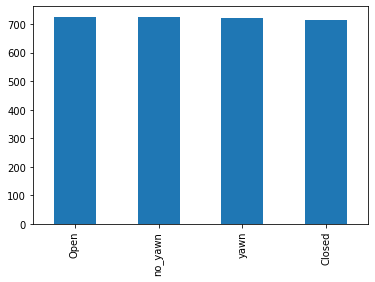

In [11]:
df['category'].value_counts().plot.bar()

In [14]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

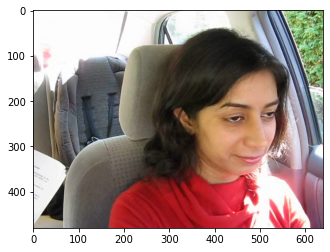

In [17]:
sample = random.choice(train_img)
image = load_img(sample)
plt.imshow(image)

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
earlystop = EarlyStopping(patience=10)

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
callbacks = [earlystop, learning_rate_reduction]

In [23]:
df["category"] = df["category"].replace({0: 'yawn', 1: 'Open',2:'no_yawn',3:'Closed'})

In [24]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

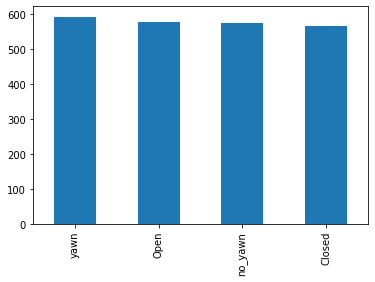

In [25]:
train_df['category'].value_counts().plot.bar()

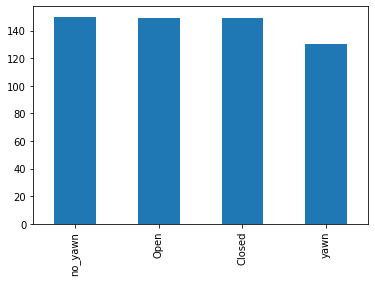

In [26]:
validate_df['category'].value_counts().plot.bar()

In [27]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [28]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2312 validated image filenames belonging to 4 classes.


In [29]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 578 validated image filenames belonging to 4 classes.


In [40]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


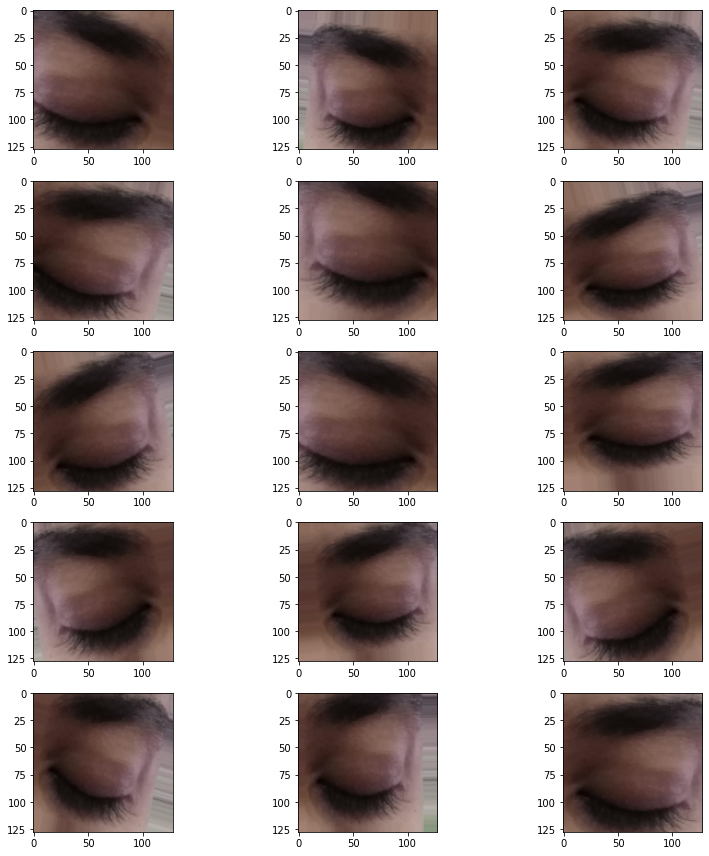

In [41]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [34]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-34-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
154/154 [==============================] - ETA: 0s - loss: 1.0515 - accuracy: 0.6443

154/154 [==============================] - 896s 6s/step - loss: 1.0515 - accuracy: 0.6443 - val_loss: 5.4789 - val_accuracy: 0.2596 - lr: 0.0010
Epoch 2/50
154/154 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.7070

154/154 [==============================] - 132s 856ms/step - loss: 0.7051 - accuracy: 0.7070 - val_loss: 5.5733 - val_accuracy: 0.2614 - lr: 0.0010
Epoch 3/50
154/154 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.7310

154/154 [==============================] - 130s 847ms/step - loss: 0.6217 - accuracy: 0.7310 - val_loss: 2.4842 - val_accuracy: 0.3789 - lr: 0.0010
Epoch 4/50
154/154 [==============================] - ETA: 0s - loss: 0.5768 - accuracy: 0.7366

154/154 [==============================] - 132s 856ms/step - loss: 0.5768 - accuracy: 0.7366 - val_loss: 0.3958 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 5/50
154/154 [==============================] - ETA: 0s - loss: 0.5122 - accuracy: 0.7571

154/154 [==============================] - 129s 838ms/step - loss: 0.5122 - accuracy: 0.7571 - val_loss: 0.3167 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/50
154/154 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.7649

154/154 [==============================] - 129s 837ms/step - loss: 0.5108 - accuracy: 0.7649 - val_loss: 0.4868 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 7/50
154/154 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.7701

154/154 [==============================] - 130s 846ms/step - loss: 0.4600 - accuracy: 0.7701 - val_loss: 0.4480 - val_accuracy: 0.7509 - lr: 0.0010
Epoch 8/50
154/154 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.7902

154/154 [==============================] - 129s 835ms/step - loss: 0.4542 - accuracy: 0.7902 - val_loss: 0.3782 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 9/50
154/154 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.7836

154/154 [==============================] - 132s 856ms/step - loss: 0.4409 - accuracy: 0.7836 - val_loss: 0.2801 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 10/50
154/154 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.7862

154/154 [==============================] - 131s 848ms/step - loss: 0.4528 - accuracy: 0.7862 - val_loss: 0.2880 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 11/50
154/154 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8045

154/154 [==============================] - 132s 859ms/step - loss: 0.4188 - accuracy: 0.8045 - val_loss: 0.5546 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 12/50
154/154 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.7967

154/154 [==============================] - 129s 839ms/step - loss: 0.4345 - accuracy: 0.7967 - val_loss: 0.2794 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 13/50
154/154 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8276

154/154 [==============================] - 131s 848ms/step - loss: 0.3711 - accuracy: 0.8276 - val_loss: 0.2571 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 14/50
154/154 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8529

154/154 [==============================] - 129s 838ms/step - loss: 0.3505 - accuracy: 0.8529 - val_loss: 0.3139 - val_accuracy: 0.8579 - lr: 0.0010
Epoch 15/50
154/154 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8663

154/154 [==============================] - 131s 850ms/step - loss: 0.3349 - accuracy: 0.8663 - val_loss: 0.2939 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 16/50
154/154 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.8855

154/154 [==============================] - 129s 835ms/step - loss: 0.3028 - accuracy: 0.8855 - val_loss: 0.4862 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 17/50
154/154 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.8751

154/154 [==============================] - 134s 867ms/step - loss: 0.3311 - accuracy: 0.8751 - val_loss: 0.2707 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 18/50
154/154 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.8851

154/154 [==============================] - 130s 846ms/step - loss: 0.2905 - accuracy: 0.8851 - val_loss: 0.2586 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 19/50
154/154 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.8990

154/154 [==============================] - 132s 853ms/step - loss: 0.2529 - accuracy: 0.8990 - val_loss: 0.3206 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 20/50
154/154 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.9042

154/154 [==============================] - 130s 841ms/step - loss: 0.2487 - accuracy: 0.9042 - val_loss: 0.1317 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 21/50
154/154 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9016

154/154 [==============================] - 132s 858ms/step - loss: 0.2695 - accuracy: 0.9016 - val_loss: 0.1123 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 22/50
154/154 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9090

154/154 [==============================] - 131s 848ms/step - loss: 0.2428 - accuracy: 0.9090 - val_loss: 0.2895 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 23/50
154/154 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9160

154/154 [==============================] - 133s 861ms/step - loss: 0.2318 - accuracy: 0.9160 - val_loss: 0.7124 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 24/50
154/154 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9103

154/154 [==============================] - 130s 845ms/step - loss: 0.2567 - accuracy: 0.9103 - val_loss: 0.1454 - val_accuracy: 0.9404 - lr: 0.0010
Epoch 25/50
154/154 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9121

154/154 [==============================] - 130s 841ms/step - loss: 0.2349 - accuracy: 0.9121 - val_loss: 0.1166 - val_accuracy: 0.9649 - lr: 0.0010
Epoch 26/50
154/154 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9173

154/154 [==============================] - 131s 848ms/step - loss: 0.2373 - accuracy: 0.9173 - val_loss: 0.1247 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 27/50
154/154 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9238

154/154 [==============================] - 129s 834ms/step - loss: 0.2369 - accuracy: 0.9238 - val_loss: 0.1888 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 28/50
154/154 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9221

154/154 [==============================] - 131s 848ms/step - loss: 0.2267 - accuracy: 0.9221 - val_loss: 0.2955 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 29/50
154/154 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9269

154/154 [==============================] - 129s 839ms/step - loss: 0.1940 - accuracy: 0.9269 - val_loss: 0.1140 - val_accuracy: 0.9702 - lr: 0.0010
Epoch 30/50
154/154 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9216

154/154 [==============================] - 130s 844ms/step - loss: 0.2352 - accuracy: 0.9216 - val_loss: 0.1822 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 31/50
154/154 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9269

154/154 [==============================] - 134s 872ms/step - loss: 0.2090 - accuracy: 0.9269 - val_loss: 0.1119 - val_accuracy: 0.9632 - lr: 0.0010
Epoch 32/50
154/154 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9168

154/154 [==============================] - 133s 863ms/step - loss: 0.2353 - accuracy: 0.9168 - val_loss: 0.2251 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 33/50
154/154 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9129

154/154 [==============================] - 134s 871ms/step - loss: 0.2375 - accuracy: 0.9129 - val_loss: 2.8591 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 34/50
154/154 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9264

154/154 [==============================] - 134s 867ms/step - loss: 0.1982 - accuracy: 0.9264 - val_loss: 0.4390 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 35/50
154/154 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9321

154/154 [==============================] - 132s 857ms/step - loss: 0.1944 - accuracy: 0.9321 - val_loss: 0.1013 - val_accuracy: 0.9614 - lr: 0.0010
Epoch 36/50
154/154 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9364

154/154 [==============================] - 135s 873ms/step - loss: 0.1827 - accuracy: 0.9364 - val_loss: 0.0597 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 37/50
154/154 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9299

154/154 [==============================] - 132s 859ms/step - loss: 0.1906 - accuracy: 0.9299 - val_loss: 0.3408 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 38/50
154/154 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9295

154/154 [==============================] - 134s 869ms/step - loss: 0.2029 - accuracy: 0.9295 - val_loss: 0.0751 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 39/50
154/154 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9343

154/154 [==============================] - 133s 863ms/step - loss: 0.1841 - accuracy: 0.9343 - val_loss: 0.1022 - val_accuracy: 0.9649 - lr: 0.0010
Epoch 40/50
154/154 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9417

154/154 [==============================] - 131s 847ms/step - loss: 0.1916 - accuracy: 0.9417 - val_loss: 0.1553 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 41/50
154/154 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9408

154/154 [==============================] - 132s 859ms/step - loss: 0.1652 - accuracy: 0.9408 - val_loss: 0.1002 - val_accuracy: 0.9614 - lr: 0.0010
Epoch 42/50
154/154 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9408

154/154 [==============================] - 134s 867ms/step - loss: 0.1793 - accuracy: 0.9408 - val_loss: 0.2411 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 43/50
154/154 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9312

154/154 [==============================] - 133s 861ms/step - loss: 0.1854 - accuracy: 0.9312 - val_loss: 0.2751 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 44/50
154/154 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9282

154/154 [==============================] - 133s 865ms/step - loss: 0.2075 - accuracy: 0.9282 - val_loss: 0.3369 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 45/50
154/154 [==============================] - ETA: 0s - loss: 0.2089 - accuracy: 0.9299

154/154 [==============================] - 133s 865ms/step - loss: 0.2089 - accuracy: 0.9299 - val_loss: 0.1503 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 46/50
154/154 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9321

154/154 [==============================] - 131s 847ms/step - loss: 0.1907 - accuracy: 0.9321 - val_loss: 0.2027 - val_accuracy: 0.9123 - lr: 0.0010


In [35]:
model.save_weights("model.h5")

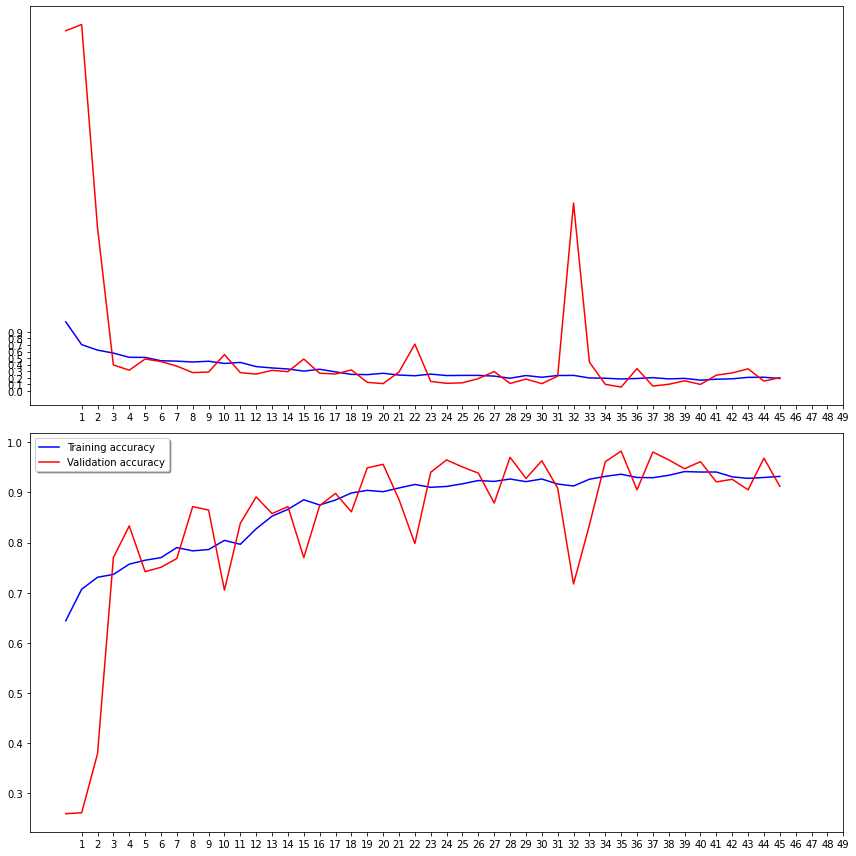

In [37]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [44]:
model.save('model.h5')

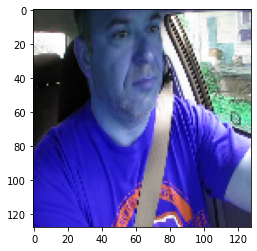

1/1 [==============================] - 0s 186ms/step
no_yawn


In [64]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('model.h5')

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('//content//drive//My Drive//capstone//train//no_yawn//2610.jpg')
img = cv2.resize(img,(128,128))
plt.imshow(img)
plt.show()
img = np.reshape(img,[1,128,128,3])

classes = model.predict(img)
classes=np.argmax(classes)
class_label=["yawn","open","no_yawn","closed"]
print( class_label[classes])